# **Clustering de empresas de crédito ativo**

O objetivo do projeto é explorar uma base de dados relacionada a créditos ativos de clientes com o intuito de identificar padrões, perfils e possíveis insights financeiros a partir dessas informações disponíveis.

# Clustering com DBSCAN

O DBSCAN é um algoritmo baseado em densidade utilizado para identificar grupos de dados com alta densidade. Seus componentes principais são:


1.   Parametro do algoritmo:




*   eps: Raio máximo para definir a vizinhança de um ponto.
*   min samples:Número mínimo de pontos necessários (incluindo o ponto central) para que uma região seja considerada densa.



2.   Tipo de pontos



*   Pontos centrais: Um ponto com pelo menos min_samples (vizinhos) em sua vizinhança (eps)
*   Pontos de borda: Pontos que estão na vizinhança mas não são densos o suficiente para serem pontos centrais são marcados como um ponto central.
*   Ruidos: Pontos que não pertencem a nenhum cluster.



**3.   Inicialização:**


*   Começa com um ponto não visitado e verifica sua vizinhança dentro do raio eps.
*   Se tem um ponto tem pelo menosvizinhos ele é marcado como um ponto central e um novo cluster é iniciado.


*   Todos os pontos em suas vizinhanças são adcionadosao cluster, e esse processo é repetido recursivamente para todos os vizinhos centrais até que todos os pontos conectados densamente sejam identificados.












In [1]:
import pandas as pd
import duckdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [2]:
# Caminho do arquivo (ajustar conforme necessário)
file_path = '/content/creditos-ativos-estados-municipios (version 1).xlsx'

# Verifique se o arquivo existe antes de carregá-lo
import os

if os.path.exists(file_path):
    excel_data = pd.ExcelFile(file_path)
    print(excel_data.sheet_names)
    df = excel_data.parse('creditos-ativos-estados-municip')
    print(df.head())
else:
    print(f"Arquivo {file_path} não encontrado.")


['creditos-ativos-estados-municip']
   mes_referencia  tipo_ente  cnpj_ente_principal uf_ente_principal  \
0          202401  MUNICÍPIO       27174135000120                ES   
1          202401  MUNICÍPIO        7165549000185                PI   
2          202401  MUNICÍPIO       25061789000111                TO   
3          202401  MUNICÍPIO       13692033000191                BA   
4          202401  MUNICÍPIO       44518405000191                SP   

  tipo_vinculo  qtde_entes situacao_debito  \
0    PRINCIPAL           1   SUSP_PROC_ADM   
1    PRINCIPAL           1         DEVEDOR   
2    PRINCIPAL           1         DEVEDOR   
3    PRINCIPAL           1   SUSP_PROC_ADM   
4    PRINCIPAL           1       PARCELADO   

                              tributo  vlr_principal   vlr_multa   vlr_juros  \
0                         19 - MULTAS           0.00     2656.61      751.82   
1  27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS      274894.35    50214.28    24768.97   
2  27 - CONTRIBUIÇÕE

In [3]:
display(df)

,mes_referencia,tipo_ente,cnpj_ente_principal,uf_ente_principal,tipo_vinculo,qtde_entes,situacao_debito,tributo,vlr_principal,vlr_multa,vlr_juros,vlr_total
0,202401,MUNICÍPIO,27174135000120,ES,PRINCIPAL,1,SUSP_PROC_ADM,19 - MULTAS,0.00,2656.61,751.82,3408.43
1,202401,MUNICÍPIO,7165549000185,PI,PRINCIPAL,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,274894.35,50214.28,24768.97,349877.60
2,202401,MUNICÍPIO,25061789000111,TO,PRINCIPAL,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,4904908.09,3284519.95,1420738.34,9610166.38
3,202401,MUNICÍPIO,13692033000191,BA,PRINCIPAL,1,SUSP_PROC_ADM,19 - MULTAS,0.00,1721.40,0.00,1721.40
4,202401,MUNICÍPIO,44518405000191,SP,PRINCIPAL,1,PARCELADO,19 - MULTAS,14047.36,0.00,4455.68,18503.04
...,...,...,...,...,...,...,...,...,...,...,...,...
197311,202411,MUNICÍPIO,33262536000134,TO,PRINCIPAL,1,PARCELADO,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,1004113.55,0.00,739084.52,1743198.07
197312,202411,MUNICÍPIO,6554018000111,PI,PRINCIPAL,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,7868.92,337.57,78.68,8285.17
197313,202411,MUNICÍPIO,3501566000195,MS,PRINCIPAL,1,SUSP_PROC_ADM,19 - MULTAS,0.00,5756.67,1220.82,6977.49
197314,202411,MUNICÍPIO,18303172000108,MG,VINCULADO,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,5681.64,1136.32,251.69,7069.65


**Dicionário da base**

**mes_referencia:** Representa o mês e o ano de referência da base de dados no formato YYYYMM.


**tipo_ente:** Descrição: Tipo de ente público relacionado à operação de crédito.


**cnpj_ente_principal:** Número do CNPJ do ente principal responsável pelo crédito.


**uf_ente_principal:** Unidade Federativa (UF) onde o ente principal está localizado.


**tipo_vinculo**: Relação do ente com a operação de crédito, podendo ser principal ou secundária.


**qtde_entes**: Quantidade de entes envolvidos na operação de crédito.


**situacao_debito**: Situação atual do débito.


**tributo**: Tipo de tributo relacionado à operação de crédito.

**vlr_principal**: Valor principal do débito em reais (R$).

**vlr_multa** : Valor da multa associada ao débito em reais (R$).

**vlr_juros**: Valor dos juros incidentes sobre o débito em reais (R$).

**vlr_total**: Soma do valor principal, multa e juros, representando o valor total do débito em reais (R$).

# O projeto

**1. Segmentar municípios e estados:**

• Criar agrupamentos que refletem características semelhantes, considerando variáveis financeiras como valores de débito principal, multas, juros e totais.

• Avaliar diferenças entre grupos de entes públicos em relação às suas situações de débito e tributos.

**2. Identificar perfis financeiros:**

• Detectar municípios ou estados com comportamentos financeiros discrepantes ou fora do padrão (outliers), como altos valores de débito ou concentração em categorias específicas de tributos.

**3. Analisar oportunidades de atuação:**

• Auxiliar na identificação de clusters que possam indicar regiões prioritárias para ações de gestão financeira, renegociação de dívidas ou intervenções administrativas.

**4. Demonstrar a eficácia de técnicas de clustering:**

• Comparar a aplicação do DBSCAN com abordagens estatísticas tradicionais, destacando como métodos baseados em densidade podem ser úteis para entender bases de dados com poucos atributos e limitações temporais.



**Contexto e Justificativa**



A base de dados apresenta informações limitadas ao ano de 2024 e possui um número reduzido de variáveis. Isso torna desafiador aplicar análises exploratórias tradicionais para identificar padrões mais profundos. O uso do DBSCAN é justificado porque:


• Permite identificar agrupamentos naturais sem a necessidade de especificar o número de clusters previamente.

• Detecta pontos de ruído e outliers, o que é relevante em contextos financeiros para identificar possíveis exceções que demandam atenção especial.

# Criando novas features com a engenharia de features

# Criando proporções financeiras:

Essas variáveis podem ajudar a entender a composição dos valores financeiros

**percentual_multa** = vlr_multa / vlr_total: Percentual de multa em relação ao total.

**percentual_juros** = vlr_juros / vlr_total: Percentual de juros em relação ao total.

**percentual_principal** = vlr_principal / vlr_total: Percentual do valor principal no total.

In [4]:
# Proporções financeiras
df['percentual_multa'] = df['vlr_multa'] / df['vlr_total']
df['percentual_juros'] = df['vlr_juros'] / df['vlr_total']
df['percentual_principal'] = df['vlr_principal'] / df['vlr_total']

# Criando a variável de risco financeiro:

Vamos primeiro explorar a distribuição da variável vlr_total que usaremos para criar uma feature de risco financeiro.

Para determinarmos as faixas para a criação de um score estatístico devemos antes explorar sua distribuição na base.

**. Explorar a Distribuição**

**Por quê?**

Entender como os valores estão distribuídos ajuda a identificar:


*   Padrões gerais: concentração em faixas específicas.
*   Outliers: valores muito altos ou baixos que podem distorcer a análise.
*   Assimetria: se os valores estão uniformemente distribuídos ou concentrados em uma extremidade (ex.: cauda longa).
* Identificar pontos de corte para categorizar ou segmentar os dados.


**2. Calcular Estatísticas Descritivas**

**Por quê?**


* As medidas descritivas fornecem uma visão resumida da centralidade (média, mediana) e dispersão (desvio padrão, IQR).
* Percentis ajudam a definir faixas ou limites, como categorias de risco ou de desempenho.


**Benefícios:**

Facilita a criação de limites objetivos, como "alto risco" ou "baixa dívida".

Permite justificar decisões baseadas em dados para dividir os valores em grupos estatisticamente significativos.

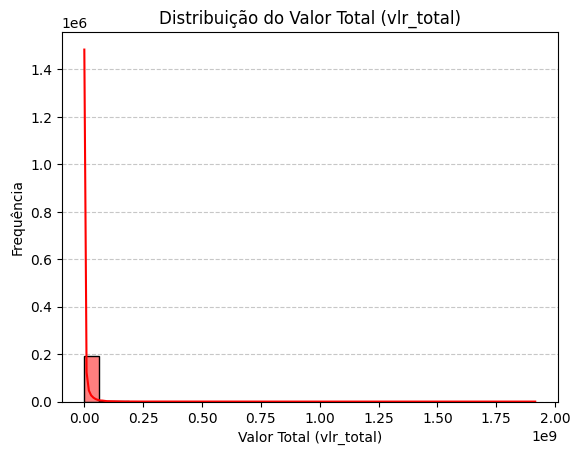

In [5]:
sns.histplot(df['vlr_total'], kde=True, bins=30, color='red')
plt.title('Distribuição do Valor Total (vlr_total)')
plt.xlabel('Valor Total (vlr_total)')
plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

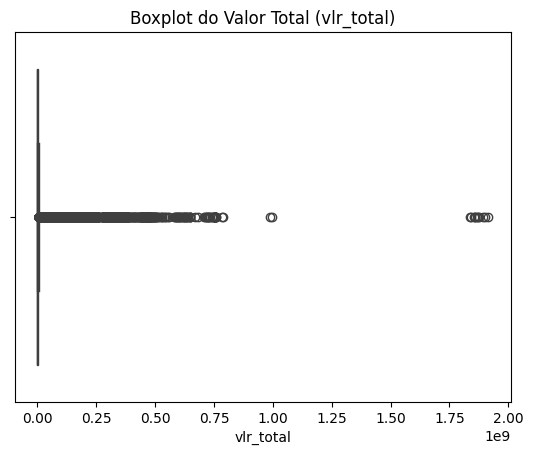

In [6]:
sns.boxplot(x=df['vlr_total'])
plt.title('Boxplot do Valor Total (vlr_total)')
plt.show()

# Assimetria (Right-Skewed)

**O que seria?**

A distribuição é inclinada para o lado direito, ou seja, tem uma cauda longa no lado positivo.
A maioria dos valores está concentrada em valores baixos, mas alguns valores extremos (outliers) puxam a distribuição para a direita.
, assim podemos ver que amaior parte dos dados está concentrada em valores extremos, enquanto os valores baixos são muito menos frequentes indicando uma distribuição desbalanceada.

**Por que a assimetria é importante nesse caso**

**Impacto nos Modelos:**

Modelos baseados em variância, como PCA, ou distâncias, como DBSCAN, podem ser distorcidos pela assimetria.
Valores altos (outliers) contribuem mais para a variância, desviando o foco dos padrões gerais.

**Verificando a distribuição do DF no Geral**

•	Calculando o coeficiente de assimetria (right skewed) para todas as variáveis numéricas:

In [7]:
skewness = df.skew(numeric_only=True)
print(skewness)

mes_referencia           0.015161
cnpj_ente_principal      1.526660
qtde_entes              10.213958
vlr_principal           26.404324
vlr_multa               19.300008
vlr_juros               29.919138
vlr_total               23.340944
percentual_multa         0.851769
percentual_juros         0.566152
percentual_principal    -0.062683
dtype: float64


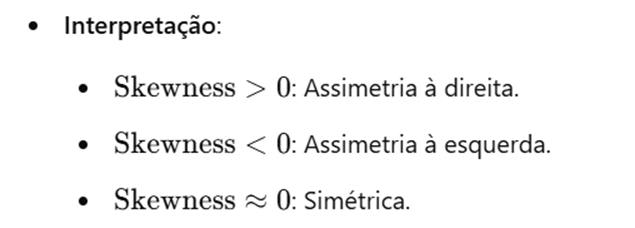

Podemos notar que várias variaveis do nosso DF são em sua maioria, assimetricas à direita pois os coeficientes > 0.

In [8]:
print(df.describe())

       mes_referencia  cnpj_ente_principal     qtde_entes  vlr_principal  \
count   197316.000000         1.973160e+05  197316.000000   1.973160e+05   
mean    202405.973829         2.288655e+13       2.053959   2.973884e+06   
std          3.155583         2.541053e+13       5.819208   1.398543e+07   
min     202401.000000         7.290002e+08       1.000000   0.000000e+00   
25%     202403.000000         6.553754e+12       1.000000   0.000000e+00   
50%     202406.000000         1.311732e+13       1.000000   8.238487e+04   
75%     202409.000000         2.716569e+13       1.000000   1.266897e+06   
max     202411.000000         9.867160e+13     107.000000   9.826881e+08   

          vlr_multa     vlr_juros     vlr_total  percentual_multa  \
count  1.973160e+05  1.973160e+05  1.973160e+05     197305.000000   
mean   9.780228e+05  2.494763e+06  6.446671e+06          0.340988   
std    5.873223e+06  1.314956e+07  2.907640e+07          0.375837   
min    0.000000e+00  0.000000e+00  0.00

Vemos também em uma das variaveis que possui assimetria à direita que a qtde_entes, vlr_principal, vlr_multa, vlr_juros, vlr_total: São variáveis numéricas, possivelmente com outliers extremos, como mostra o valor máximo bem maior que o percentil 75.

Percentuais (percentual_multa, percentual_juros, percentual_principal):
Essas variáveis têm valores entre 0 e 1, o que indica que já estão escalonadas e provavelmente não têm outliers significativos.

**Matriz de Correlação**

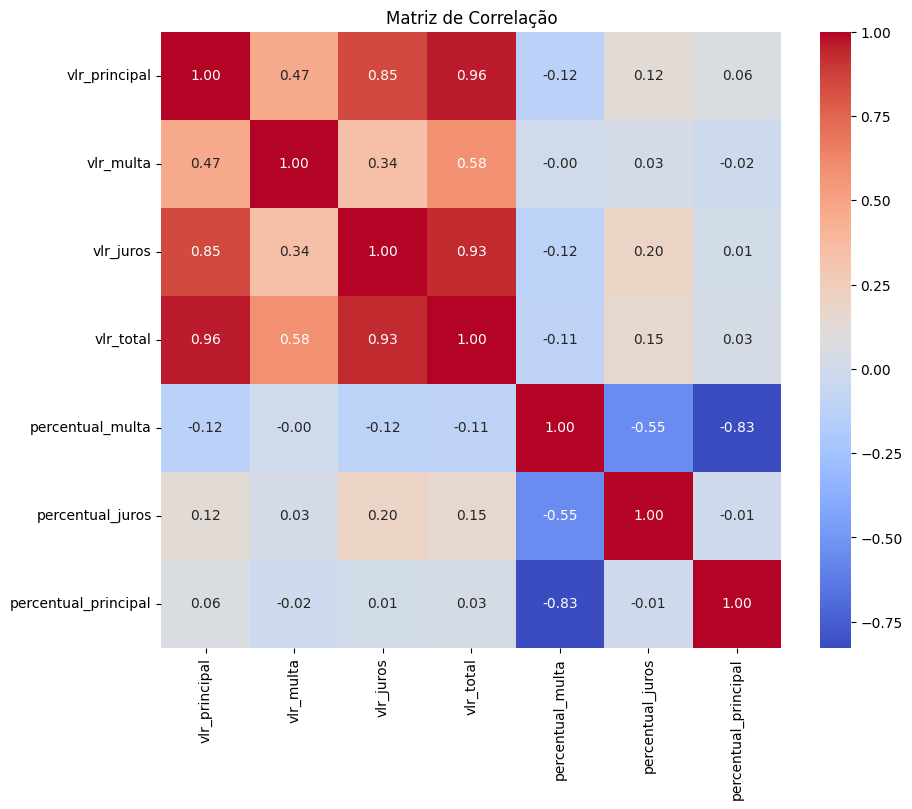

In [9]:
# Selecionar variáveis para análise de correlação
features = ['vlr_principal', 'vlr_multa', 'vlr_juros', 'vlr_total',
            'percentual_multa', 'percentual_juros', 'percentual_principal']

# Criar a matriz de correlação
correlation_matrix = df[features].corr()

# Exibir a matriz de correlação com um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

##**Correlação Altamente Positiva:**

vlr_principal, vlr_juros, e vlr_total:
Correlação forte (>0.85>0.85), indicando que essas variáveis são altamente redundantes.

Isso ocorre porque o vlr_total parece ser uma soma direta ou quase direta de vlr_principal, vlr_juros, e possivelmente outros componentes.

##**Impacto da Correlação no DBSCAN**

**Redundância:**

Variáveis altamente correlacionadas como vlr_principal, vlr_juros, e vlr_total podem inflar artificialmente as distâncias entre os pontos, dificultando a formação de clusters.

**Distorção de Resultados:**

Variáveis correlacionadas podem sobrecarregar o cálculo de densidade, dando mais peso a informações repetitivas.

**Aumento da Dimensionalidade Efetiva:**

Mesmo com poucas variáveis, a redundância cria um "efeito de alta dimensionalidade", onde os pontos tendem a parecer mais distantes do que realmente estão, prejudicando a formação de clusters.

# Impacto da Correlação no DBSCAN

**Redundância:**

*  Variáveis altamente correlacionadas como vlr_principal, vlr_juros, e vlr_total podem inflar artificialmente as distâncias entre os pontos, dificultando a formação de clusters.


**Distorção de Resultados:**

Variáveis correlacionadas podem sobrecarregar o cálculo de densidade, dando

*  Variáveis correlacionadas podem sobrecarregar o cálculo de densidade, dando mais peso a informações repetitivas.

**Aumento da Dimensionalidade Efetiva:**

Mesmo com poucas variáveis, a redundância cria um “efeito de alta dimensionalidade”, onde os pontos tendem a parecer mais distantes do que realmente estão, prejudicando a formação de clusters.

# Criando uma variavél de Score de Crédito

# **Classificação com Regressão Logística**
Para construir a base necessária ao cálculo do score de crédito, utilizamos um modelo de regressão logística para classificar os clientes (entes) em duas categorias principais:

Em Dia: Clientes que estão com seus compromissos financeiros regularizados.

Inadimplente: Clientes que possuem pendências financeiras ativas.


A regressão logística foi escolhida devido à sua capacidade de estimar probabilidades para cada classe, o que nos permite não apenas realizar classificações binárias, mas também obter um grau de confiança associado a cada previsão.

In [10]:
# Normalizar os nomes das colunas para evitar espaços ou caracteres estranhos
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Pré-processamento
# Tratar valores ausentes
df.fillna(0, inplace=True)

# Transformar `situacao_debito` em uma variável binária
    #1 = PARCELADO (em dia), 0 = DEVEDOR (inadimplente)
df['situacao_debito_bin'] = df['situacao_debito'].apply(lambda x: 1 if x == 'PARCELADO' else 0)

# Criar novas colunas de análise
  #Realizando uma engenharia de features como fizemos acima
  #percentual_multa= vlr_multa / vlr_total: Percentual de multa em relação ao total.
  #percentual_juros = vlr_juros / vlr_total: Percentual de juros em relação ao total.
  #percentual_principal = vlr_principal / vlr_total: Percentual do valor principal no total.

df['percentual_multa'] = (df['vlr_multa'] / df['vlr_total']).fillna(0)
df['percentual_juros'] = (df['vlr_juros'] / df['vlr_total']).fillna(0)
df['percentual_principal'] = df['vlr_principal'] / df['vlr_total'].fillna(0)

# Separar variáveis independentes e target (binária)

X = df[['uf_ente_principal', 'tipo_ente', 'vlr_principal', 'percentual_multa', 'percentual_juros','percentual_principal']]
y = df['situacao_debito_bin']

# Configurar Pré-processamento
    #Definir quais colunas são categóricas e quais são numéricas
categorical_features = ['uf_ente_principal', 'tipo_ente']
numerical_features = ['vlr_principal', 'percentual_multa', 'percentual_juros', 'percentual_principal']

### Processamento ##
  # Usar ColumnTransformer para combinar transformações numéricas e categóricas
preprocessor = ColumnTransformer( #O ColumnTransformer é usado para aplicar transformações específicas em diferentes tipos de colunas
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Substituir Null pela média
            ('scaler', StandardScaler()) # Aplicar StandardScaler nas colunas numéricas para padronizá-la (z-score)
        ]), numerical_features),  #Aplicar OneHotEncoder nas colunas categóricas para transformá-las em formato numérico
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features), # Aplicar StandardScaler nas colunas numéricas para padronizá-la
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # Aplicar OneHotEncoder nas colunas categóricas para transformá-las em formato numérico
#     ]
# )

#  Criar o Pipeline usando a sklearn.pipeline import Pipeline
     #O pipeline combina o pré-processamento e o modelo em um fluxo único
model_pipeline = Pipeline(steps=[ # 1 passo: pré-processar os dados
    ('preprocessor', preprocessor), # 2 passo: aplicar o modelo de Regressão Logística
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

#Divisão e Avaliação com K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(accuracy_score)

# Avaliação com validação cruzada
scores = cross_val_score(model_pipeline, X, y, cv=kf, scoring=scorer)
print(f"Acurácia Média: {np.mean(scores):.4f}")
print(f"Desvio Padrão das Acurácias: {np.std(scores):.4f}")

# Treinar o Modelo Final
model_pipeline.fit(X, y)

#Exportar o Pipeline
    #Salvar o pipeline treinado
joblib.dump(model_pipeline, 'pipeline_creditos_binario.pkl')

Acurácia Média: 0.8932
Desvio Padrão das Acurácias: 0.0008


['pipeline_creditos_binario.pkl']

# Treinamento do Modelo:

O modelo foi treinado utilizando as variáveis financeiras da base de dados, como:

Valores principais de débitos (vlr_principal),

Proporção de multas e juros em relação ao valor total (percentual_multa e percentual_juros),

Informações categóricas (como o tipo do ente e a UF).


Essas variáveis foram pré-processadas com técnicas como normalização e codificação para garantir um formato adequado ao modelo.


**Previsão Binária:**

A regressão logística usa uma combinação linear das variáveis preditoras e as transforma em uma probabilidade por meio da função sigmoide:

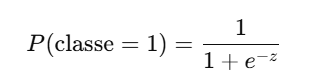

Onde
𝑧
z é a soma ponderada das variáveis preditoras.


Com base nessa probabilidade, o modelo classifica o cliente:


Classe 1 (Em Dia): Quando
𝑃
(
Em Dia
)
>
0.5
P(Em Dia)>0.5.


Classe 0 (Inadimplente): Quando
𝑃
(
Em Dia
)
≤
0.5
P(Em Dia)≤0.5.


Probabilidade como Base do Score:

Além da classificação binária, utilizamos a probabilidade gerada pelo modelo para medir a confiança de que um cliente pertence à classe "Em Dia".

Essa probabilidade é posteriormente escalada para um intervalo de 0 a 1000, formando a base do score de crédito.

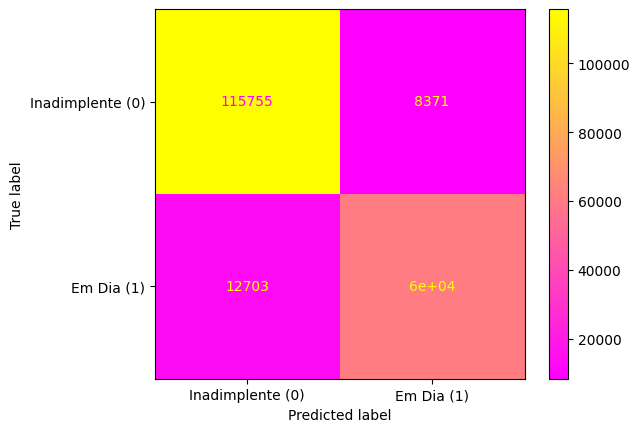

In [11]:
# Prever os valores do conjunto de dados
y_pred = model_pipeline.predict(X)

# Gerar a matriz de confusão
conf_matrix = confusion_matrix(y, y_pred)

# Exibir a matriz de confusão de forma visual
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Inadimplente (0)', 'Em Dia (1)'])
disp.plot(cmap='spring')


# Interpretação dos Valores

Verdadeiro Negativo (TN): 115,747



*   O modelo previu corretamente que 115,747 clientes estavam Inadimplentes e realmente estavam.



Falso Positivo (FP): 8,379


*   O modelo classificou 8,379 clientes como Em Dia, mas eles estavam na verdade Inadimplentes.
*   Isso pode indicar que o modelo está sendo um pouco "otimista" em prever que clientes estão em dia.



Falso Negativo (FN): 12,694


*   O modelo classificou 12,694 clientes como Inadimplentes, mas eles estavam Em Dia.
*  Esses erros podem ser críticos, especialmente se "Em Dia" for uma classe importante para o seu negócio (por exemplo, para priorizar ações).


Verdadeiro Positivo (TP): 60,000


*   O modelo previu corretamente que 60,000 clientes estavam Em Dia e realmente estavam.


# Criando o Score de Crédito
 Construir um score de crédito que possa ser integrado à base de dados como uma nova feature, enriquecendo-a para análises futuras. Esse score será calculado com base no modelo de classificação desenvolvido, que avalia a probabilidade de um ente estar em dia com suas obrigações financeiras.

 **Definição do Score:**

O score será calculado a partir da probabilidade do modelo de classificação (regressão logística) prever que um ente está "Em Dia" (classe 1).

A probabilidade será escalada para um intervalo de 0 a 1000, representando o grau de confiança do modelo:



*   Score próximo a 1000: Alta probabilidade de estar em dia.
*   Score próximo a 0: Alta probabilidade de estar inadimplente.


**Propósito do Score**:

Representar o risco de crédito de forma escalável e interpretável.
Integrar esse score à base de dados como uma nova coluna, facilitando sua utilização em etapas posteriores.

Para construir um score de 0 a 1000 baseado nessa classificação, podemos usar a probabilidade prevista pelo modelo (saída de predict_proba) como base e escalá-la para o intervalo desejado. Essa abordagem permite que o score represente a confiança do modelo de que um ente está "Em Dia" (classe 1).

# Como Obter as Probabilidades:

*  O método predict_proba retorna a probabilidade de cada classe para cada observação.

*  Vamos usar a probabilidade associada à classe "Em Dia" (1). Item da lista


Escalar as Probabilidades para o Intervalo [0, 1000]:


*   Multiplicar a probabilidade pela escala máxima (1000).

Gerar o Score:

Para cada observação, o score será:

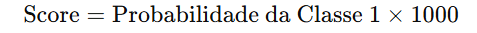

In [12]:
# Obter as probabilidades previstas pelo modelo
probabilidades = model_pipeline.predict_proba(X)

# Selecionar a probabilidade da classe 1 (Em Dia)
prob_classe_1 = probabilidades[:, 1]

# Escalar para o intervalo de 0 a 1000
score = (prob_classe_1 * 1000).astype(int)

# Criar uma cópia do DataFrame original antes de adicionar a coluna
# df_resultado = df.copy()

# Adicionar o score ao DataFrame original
df['score'] = score

# Exibir algumas observações para verificar
print(df[['situacao_debito', 'situacao_debito_bin', 'score']].head())


  situacao_debito  situacao_debito_bin  score
0   SUSP_PROC_ADM                    0      0
1         DEVEDOR                    0    156
2         DEVEDOR                    0     37
3   SUSP_PROC_ADM                    0      0
4       PARCELADO                    1    701


In [13]:
display(df)

,mes_referencia,tipo_ente,cnpj_ente_principal,uf_ente_principal,tipo_vinculo,qtde_entes,situacao_debito,tributo,vlr_principal,vlr_multa,vlr_juros,vlr_total,percentual_multa,percentual_juros,percentual_principal,situacao_debito_bin,score
0,202401,MUNICÍPIO,27174135000120,ES,PRINCIPAL,1,SUSP_PROC_ADM,19 - MULTAS,0.00,2656.61,751.82,3408.43,0.779423,0.220577,0.000000,0,0
1,202401,MUNICÍPIO,7165549000185,PI,PRINCIPAL,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,274894.35,50214.28,24768.97,349877.60,0.143520,0.070793,0.785687,0,156
2,202401,MUNICÍPIO,25061789000111,TO,PRINCIPAL,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,4904908.09,3284519.95,1420738.34,9610166.38,0.341776,0.147837,0.510387,0,37
3,202401,MUNICÍPIO,13692033000191,BA,PRINCIPAL,1,SUSP_PROC_ADM,19 - MULTAS,0.00,1721.40,0.00,1721.40,1.000000,0.000000,0.000000,0,0
4,202401,MUNICÍPIO,44518405000191,SP,PRINCIPAL,1,PARCELADO,19 - MULTAS,14047.36,0.00,4455.68,18503.04,0.000000,0.240808,0.759192,1,701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197311,202411,MUNICÍPIO,33262536000134,TO,PRINCIPAL,1,PARCELADO,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,1004113.55,0.00,739084.52,1743198.07,0.000000,0.423982,0.576018,1,959
197312,202411,MUNICÍPIO,6554018000111,PI,PRINCIPAL,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,7868.92,337.57,78.68,8285.17,0.040744,0.009496,0.949760,0,333
197313,202411,MUNICÍPIO,3501566000195,MS,PRINCIPAL,1,SUSP_PROC_ADM,19 - MULTAS,0.00,5756.67,1220.82,6977.49,0.825035,0.174965,0.000000,0,0
197314,202411,MUNICÍPIO,18303172000108,MG,VINCULADO,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,5681.64,1136.32,251.69,7069.65,0.160732,0.035601,0.803666,0,108


# Como a Probabilidade é Calculada?

A regressão logística calcula a probabilidade com base na combinação linear das variáveis preditoras
𝑋
X e a aplicação de uma função sigmoide:

Passos:
Cálculo da Combinação Linear:

O modelo calcula uma soma ponderada das variáveis
𝑋
X com os coeficientes
𝑤
w: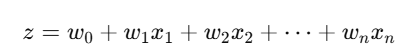

Aqui,
𝑧
z é chamado de logit ou escore linear.
Aplicação da Função Sigmoide:

O valor
𝑧
z é transformado em uma probabilidade com a função sigmoide: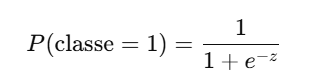

Exemplo de Função Sigmoide:

Para
𝑧
=
0
z=0: Probabilidade = 0.5.


Para
𝑧
=
2
z=2: Probabilidade = 0.88.

Para
𝑧
=
−
2
z=−2: Probabilidade = 0.12.


O Papel do Threshold (Limiar de Decisão)
O modelo usa um threshold (geralmente 0.5) para converter a probabilidade em uma previsão de classe:

Se
𝑃
(
classe
=
1
)
>
0.5
P(classe=1)>0.5: Previsão = "Em Dia" (1).
Se
𝑃
(
classe
=
1
)
≤
0.5
P(classe=1)≤0.5: Previsão = "Inadimplente" (0).

Ajustando o Threshold:

Aumentar o threshold (e.g., 0.7) reduz os falsos positivos (FP), mas pode aumentar os falsos negativos (FN).


Diminuir o threshold (e.g., 0.3) reduz os falsos negativos, mas aumenta os falsos positivos.

# Lidando com Outiliers, Alta Dimensionalidade e variáveis Altamente Correlacionadas

# Outiliers


Variáveis financeiras (vlr_principal, vlr_multa, vlr_juros, vlr_total) possuem valores máximos que são muito maiores que o percentil 75.
Isso confirma que são right-skewed (assimétricas à direita).
lgumas variáveis, como vlr_total, possuem valores mínimos de 0.
Zeros são válidos, mas podem precisar de um tratamento especial, especialmente na transformação logarítmica


# Transformação Logarítmica para Variáveis Assimétricas

**Como Funciona:**

O logaritmo comprime os valores à medida que eles crescem, reduzindo a diferença entre valores pequenos e grandes.
Adicionamos
+
1
+1 para evitar problemas com
𝑥
=
0
x=0 (pois
log
⁡
(
0
)
log(0) é indefinido)

In [14]:
#Criando as novas colunas transformadas e as adcionando ao DF

df['vlr_principal_log'] = np.log1p(df['vlr_principal'])
df['vlr_multa_log'] = np.log1p(df['vlr_multa'])
df['vlr_juros_log'] = np.log1p(df['vlr_juros'])
df['vlr_total_log'] = np.log1p(df['vlr_total'])


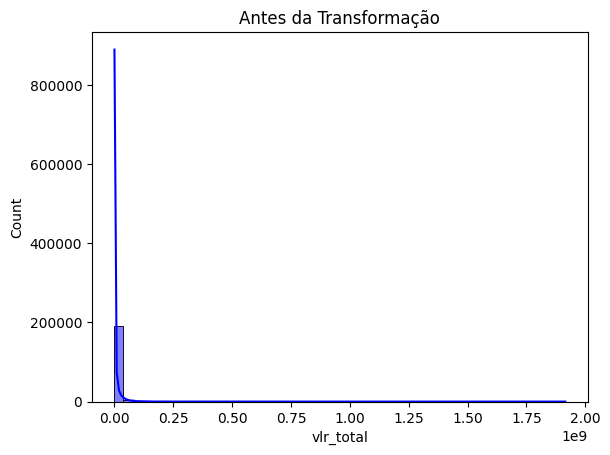

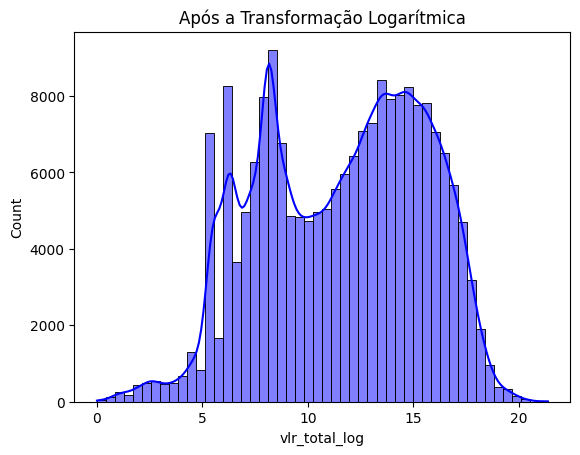

In [15]:
# Antes da transformação
sns.histplot(df['vlr_total'], kde=True, bins=50, color='blue')
plt.title('Antes da Transformação')
plt.show()

# Depois da transformação
sns.histplot(df['vlr_total_log'], kde=True, bins=50, color='blue')
plt.title('Após a Transformação Logarítmica')
plt.show()


# Aplicando as colunas transformadas pelo Log

In [16]:
#Excluir as colunas originais do DF para usarmos as novas transformadas pelo Log
df = df.drop(columns=['vlr_principal', 'vlr_multa', 'vlr_juros', 'vlr_total'])

#Visualizar o DataFrame atualizado
print(df.head())


   mes_referencia  tipo_ente  cnpj_ente_principal uf_ente_principal  \
0          202401  MUNICÍPIO       27174135000120                ES   
1          202401  MUNICÍPIO        7165549000185                PI   
2          202401  MUNICÍPIO       25061789000111                TO   
3          202401  MUNICÍPIO       13692033000191                BA   
4          202401  MUNICÍPIO       44518405000191                SP   

  tipo_vinculo  qtde_entes situacao_debito  \
0    PRINCIPAL           1   SUSP_PROC_ADM   
1    PRINCIPAL           1         DEVEDOR   
2    PRINCIPAL           1         DEVEDOR   
3    PRINCIPAL           1   SUSP_PROC_ADM   
4    PRINCIPAL           1       PARCELADO   

                              tributo  percentual_multa  percentual_juros  \
0                         19 - MULTAS          0.779423          0.220577   
1  27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS          0.143520          0.070793   
2  27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS          0.341776          

# PCA
Vimos que as variaveis vlr_principal, vlr_juros, e vlr_total são altamente correlacionadas, ao usar um modelo como o DBSCAN pode criar redundância desnecessária. Usando a PCA podemos combinar essas variaveis em 1 ou 2 componentes principais, que são as combinações lineares das variáveis originais:


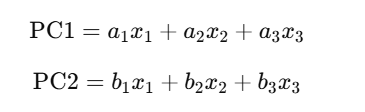


a
i
​
 ,b
i
​
 : coeficientes que determinam a contribuição de cada variável para o componente.

A PCA combina as variáveis em 1 ou 2 componentes principais, reduzindo a colinearidade entre elas. Isso elimina a inflação nas distâncias artificiais entre os pontos e minimiza redundâncias, ao mesmo tempo preservando a maior parte da informação presente nos dados.
Em cenários de alta dimensionalidade onde há muitas variáveis em relação ao número de observações, as distâncias entre os pontos podem se tornar maiores (não necessariamente correlacionadas).

Nesses casos a PCA trabalha para reduzir a dimensionalidade, simplificando os dados em componentes principais que ocupam espaços menores e mais representativos



In [17]:
# Verificar os tipos de dados no DataFrame
print(df.info())

# Verificar as primeiras linhas de cada coluna para identificar valores categóricos ou não numéricos
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197316 entries, 0 to 197315
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   mes_referencia        197316 non-null  int64  
 1   tipo_ente             197316 non-null  object 
 2   cnpj_ente_principal   197316 non-null  int64  
 3   uf_ente_principal     197316 non-null  object 
 4   tipo_vinculo          197316 non-null  object 
 5   qtde_entes            197316 non-null  int64  
 6   situacao_debito       197316 non-null  object 
 7   tributo               197316 non-null  object 
 8   percentual_multa      197316 non-null  float64
 9   percentual_juros      197316 non-null  float64
 10  percentual_principal  197305 non-null  float64
 11  situacao_debito_bin   197316 non-null  int64  
 12  score                 197316 non-null  int64  
 13  vlr_principal_log     197316 non-null  float64
 14  vlr_multa_log         197316 non-null  float64
 15  

In [18]:
# Selecionar somente colunas relevantes para a PCA, excluindo variaveis temporais, identificador numérico...
columns_for_pca = [
    'qtde_entes',
    #'score',
    'percentual_multa',
    'percentual_juros',
    'percentual_principal',
    'vlr_principal_log',
    'vlr_multa_log',
    'vlr_juros_log',
    'vlr_total_log'
]

# Criar DF apenas com essas colunas
df_pca = df[columns_for_pca]


In [19]:
#Substituindo valores ausentes por média
df_pca.fillna(df_pca.mean(), inplace=True)

#Padronizar as colunas com Standard
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

#Aplicar a PCA com todas as componentes
pca = PCA(n_components=len(df_pca.columns))
pca_result = pca.fit_transform(df_scaled)

<ipython-input-19-dfced793ef7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca.fillna(df_pca.mean(), inplace=True)


# Variância na PCA

Na PCA , a variância é usada para determinar quais componentes carregam mais informações:



1.   Cada componente principal explica uma porção da variância total nos dados.
2.   A variância explicada ajuda a decidir quantos componentes devem ser mantidos para capturar a maior parte da informação.



In [20]:
# Visualizar a variância explicada
print("Variância explicada por cada componente:")
print(pca.explained_variance_ratio_)

print("Variância explicada acumulada:")
print(pca.explained_variance_ratio_.cumsum())

Variância explicada por cada componente:
[5.28471036e-01 1.74251548e-01 1.43084102e-01 1.23517866e-01
 2.22075212e-02 6.08325877e-03 2.37638947e-03 8.27805437e-06]
Variância explicada acumulada:
[0.52847104 0.70272258 0.84580669 0.96932455 0.99153207 0.99761533
 0.99999172 1.        ]


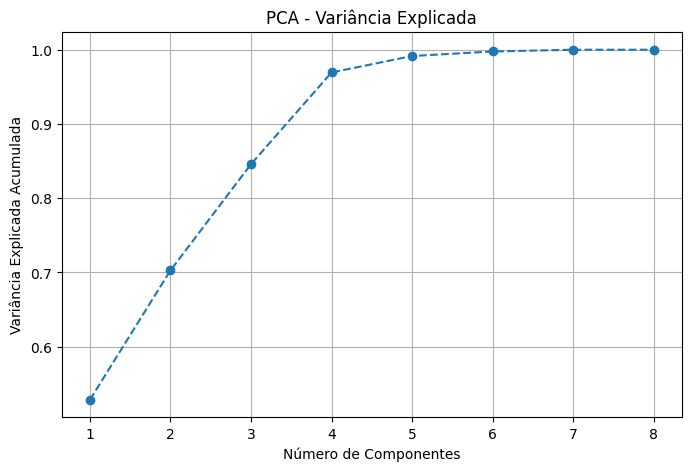

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(df_pca.columns) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('PCA - Variância Explicada')
plt.grid()
plt.show()


# Método do Cotovelo

O método do cotovelo identifica o ponto onde a curva começa a se achatar (o "cotovelo"), indicando que componentes adicionais explicam apenas alguns incrementos mínimos da variância e não são tão significativos assim.

**Ponto antes do achatamento:** Este é o número ideal de componentes principais porque inclui a maior parte da informação relevante, sem incluir componentes redundantes ou desnecessários

**Com base na análise vamos reduzir o número de componentes para 4.**

In [22]:
#Ajustando a PCA para 4 componentes
pca = PCA(n_components=4)
pca_result = pca.fit_transform(df_scaled)

#Verificar o formato
print(pca_result.shape)

(197316, 4)


# Combinar a PCA + Variáveis adicionais

In [23]:
#Selecionar as variáveis adicionais
variables_to_include = ['score', 'situacao_debito_bin']

#Padronizar as variáveis adicionais
scaler_additional = StandardScaler()
variables_scaled = scaler_additional.fit_transform(df[variables_to_include])

In [24]:
# Combinar os componentes principais da PCA com as variáveis adicionais
X_combinacao = np.hstack([pca_result, variables_scaled])

# Aplicando o DBSCAN

In [25]:
#Aplicar o DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_combinacao)

# Adicionar os clusters ao DF
df['cluster'] = clusters

# contagem de clusters
print(df['cluster'].value_counts())

cluster
 0      120692
 1       72207
 3         741
-1         353
 6         158
         ...  
 141         5
 206         5
 157         5
 228         5
 73          5
Name: count, Length: 241, dtype: int64


In [26]:
display(df)

,mes_referencia,tipo_ente,cnpj_ente_principal,uf_ente_principal,tipo_vinculo,qtde_entes,situacao_debito,tributo,percentual_multa,percentual_juros,percentual_principal,situacao_debito_bin,score,vlr_principal_log,vlr_multa_log,vlr_juros_log,vlr_total_log,cluster
0,202401,MUNICÍPIO,27174135000120,ES,PRINCIPAL,1,SUSP_PROC_ADM,19 - MULTAS,0.779423,0.220577,0.000000,0,0,0.000000,7.885183,6.623826,8.134300,0
1,202401,MUNICÍPIO,7165549000185,PI,PRINCIPAL,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,0.143520,0.070793,0.785687,0,156,12.524146,10.824075,10.117387,12.765342,0
2,202401,MUNICÍPIO,25061789000111,TO,PRINCIPAL,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,0.341776,0.147837,0.510387,0,37,15.405747,15.004731,14.166688,16.078332,0
3,202401,MUNICÍPIO,13692033000191,BA,PRINCIPAL,1,SUSP_PROC_ADM,19 - MULTAS,1.000000,0.000000,0.000000,0,0,0.000000,7.451474,0.000000,7.451474,0
4,202401,MUNICÍPIO,44518405000191,SP,PRINCIPAL,1,PARCELADO,19 - MULTAS,0.000000,0.240808,0.759192,1,701,9.550261,0.000000,8.402159,9.825744,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197311,202411,MUNICÍPIO,33262536000134,TO,PRINCIPAL,1,PARCELADO,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,0.000000,0.423982,0.576018,1,959,13.819617,0.000000,13.513169,14.371233,1
197312,202411,MUNICÍPIO,6554018000111,PI,PRINCIPAL,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,0.040744,0.009496,0.949760,0,333,8.970803,5.824731,4.378019,9.022343,0
197313,202411,MUNICÍPIO,3501566000195,MS,PRINCIPAL,1,SUSP_PROC_ADM,19 - MULTAS,0.825035,0.174965,0.000000,0,0,0.000000,8.658288,7.108097,8.850588,0
197314,202411,MUNICÍPIO,18303172000108,MG,VINCULADO,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,0.160732,0.035601,0.803666,0,108,8.645171,7.036430,5.532163,8.863708,0


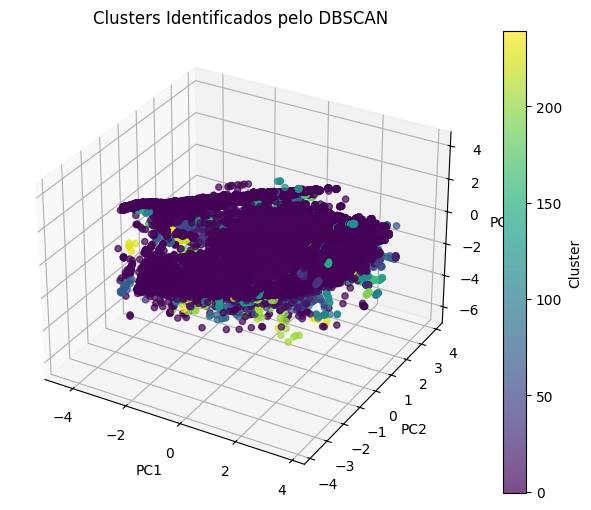

In [27]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=clusters, cmap='viridis', alpha=0.7)
ax.set_title("Clusters Identificados pelo DBSCAN")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.colorbar(sc, label="Cluster")
plt.show()


# Análise de total de clientes por Cluster e Score

In [40]:
query = """
  SELECT
    cluster,
    COUNT(*) AS total_clientes,
    score,
    AVG(score) AS media_score,
    AVG(vlr_total_log) AS media_vlr_total_log,
    AVG(percentual_multa) AS media_percentual_multa,
    AVG(percentual_principal) AS media_percentual_principal
  FROM df
  GROUP BY cluster,score
  ORDER BY total_clientes DESC
"""
result = duckdb.query(query).to_df()
display(result)


,cluster,total_clientes,score,media_score,media_vlr_total_log,media_percentual_multa,media_percentual_principal
0,0,52925,0,0.0,7.584436,0.928563,0.000571
1,0,950,1,1.0,12.734543,0.620004,0.100853
2,1,914,977,977.0,14.490507,0.002692,0.401924
3,1,900,980,980.0,14.533743,0.002023,0.392353
4,1,859,978,978.0,14.514230,0.002107,0.402731
...,...,...,...,...,...,...,...
4409,61,1,873,873.0,19.349203,0.066190,0.271312
4410,99,1,825,825.0,13.918024,0.096985,0.484924
4411,163,1,555,555.0,11.262131,0.000003,0.597095
4412,225,1,5,5.0,16.224567,0.454056,0.403606


In [28]:
query = """
  SELECT
    cluster,
    COUNT(*) AS total_registros
  FROM df
  GROUP BY cluster
  ORDER BY total_registros DESC
"""
result = duckdb.query(query).to_df()
display(result)

,cluster,total_registros
0,0,120692
1,1,72207
2,3,741
3,-1,353
4,6,158
...,...,...
236,234,5
237,73,5
238,141,5
239,157,5


# Clusters de maior Score

**Valores altos e consistentes:** Os scores estão acima de 896, com a maioria acima de 970 nos clusters 2,3 e 4. Isso reforça que esses clientes estão com  um comportamento confiável


Embora a maioria dos clientes seja rotulada como "DEVEDOR", **os % de multa são 0** Isso pode significar que os débitos estão sendo gerenciados de forma consistente por parte dos clientes devedores, mas ainda precisam de regularização.

**% de Juros:** Valores médios estão em torno de 0.7, indicando que juros representam uma parte significativa dos débitos totais.

**% Principal:** Com valores próximos de 0.3, o valor principal da dívida é proporcionalmente menor, o que pode refletir em uma boa capacidade de pagamento.

Algumas entradas possuem situação como "SUSP_PROC_JUD", o que pode indicar processos judiciais em andamento para resolver os débitos. Esses clientes podem estar regularizando suas pendências.



In [44]:
query = """
  SELECT *
  FROM df
  WHERE cluster = 2 OR cluster = 3 OR cluster = 4
"""
result = duckdb.query(query).to_df()
display(result)


,mes_referencia,tipo_ente,cnpj_ente_principal,uf_ente_principal,tipo_vinculo,qtde_entes,situacao_debito,tributo,percentual_multa,percentual_juros,percentual_principal,situacao_debito_bin,score,vlr_principal_log,vlr_multa_log,vlr_juros_log,vlr_total_log,cluster
0,202401,ESTADO,5054861000176,PA,VINCULADO,75,SUSP_PROC_ADM,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,0.0,0.716838,0.283162,0,892,12.334308,0.0,13.263138,13.596043,2
1,202401,MUNICÍPIO,83039842000184,SC,PRINCIPAL,1,DEVEDOR,06 - PASEP,0.0,0.705016,0.294984,0,979,10.452978,0.0,11.324260,11.673791,3
2,202401,MUNICÍPIO,87612834000136,RS,PRINCIPAL,1,DEVEDOR,06 - PASEP,0.0,0.714701,0.285299,0,972,11.621948,0.0,12.540271,12.876161,3
3,202401,MUNICÍPIO,87612990000105,RS,PRINCIPAL,1,DEVEDOR,06 - PASEP,0.0,0.714825,0.285175,0,972,11.526613,0.0,12.445544,12.781260,3
4,202401,MUNICÍPIO,16233439000102,BA,PRINCIPAL,1,SUSP_PROC_JUD,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,0.0,0.306283,0.693717,0,896,13.452232,0.0,12.634679,13.817923,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,202411,MUNICÍPIO,76206606000140,PR,PRINCIPAL,1,SUSP_PROC_JUD,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,0.0,0.745679,0.254321,0,988,13.757586,0.0,14.833282,15.126743,3
765,202411,MUNICÍPIO,46634614000126,SP,VINCULADO,2,SUSP_PROC_ADM,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,0.0,0.648260,0.351740,0,971,11.230993,0.0,11.842387,12.275848,3
766,202411,ESTADO,42498600000171,RJ,PRINCIPAL,1,SUSP_PROC_ADM,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,0.0,0.683444,0.316556,0,893,9.739812,0.0,10.509425,10.890027,3
767,202411,MUNICÍPIO,16257719000142,BA,PRINCIPAL,1,SUSP_PROC_JUD,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,0.0,0.292204,0.707796,0,892,15.372602,0.0,14.487897,15.718201,3


# Oportunidades:

Clientes nesse grupo podem estar próximos de regularizar seus débitos, podem estra tentando regularizar pagando suas parcelas mesmo que ainda não tenha conseguido quitar o valor total da dívida.

 Estratégias para finalização como renegociações ou incentivos de regularização, podem ser eficazes nesse grupo.

Clientes com status "SUSP_PROC_JUD" podem demandar atenção especial para ajudar na conclusão dos processos judiciais.

# Cluster de Menor Score

**% de Multa:**

O percentual de multa varia amplamente indicando que alguns clientes possuem multas altas enquanto outros têm valores baixos, estes estão em maioria nos clusters 0 e 1 (também presentes em outros considerados outiliers)
Um % de multa elevado pode indicar dívidas penalizadas por atrasos prolongados.

**%  Principal:**

Clientes com valores expressivos no percentual principal indicam que o valor principal da dívida constitui a maior parte do total.

Clientes com percentual_principal 0.0 provavelmente têm maior dificuldade em pagar a dívida principal, já que a maior parte do débito está composta de multas e juros.

**Score Baixo e Percentual de Multa Alto:**

Clientes com scores muito baixos (próximos a 0) e percentual_multa elevado podem ser tratados com estratégias de renegociação ou desconto de multas para incentivar o pagamento.

**Score Médio e % Principal elevado:**

Clientes com scores mais altos (próximos a 99) e percentual_principal maior que 0.7 podem ser bons candidatos para programas de fidelização, já que possuem menor risco.

In [42]:
query = """
  SELECT *
  FROM df
  WHERE cluster = 0 OR cluster = 1
"""
result = duckdb.query(query).to_df()
display(result)


,mes_referencia,tipo_ente,cnpj_ente_principal,uf_ente_principal,tipo_vinculo,qtde_entes,situacao_debito,tributo,percentual_multa,percentual_juros,percentual_principal,situacao_debito_bin,score,vlr_principal_log,vlr_multa_log,vlr_juros_log,vlr_total_log,cluster
0,202401,MUNICÍPIO,27174135000120,ES,PRINCIPAL,1,SUSP_PROC_ADM,19 - MULTAS,0.779423,0.220577,0.000000,0,0,0.000000,7.885183,6.623826,8.134300,0
1,202401,MUNICÍPIO,7165549000185,PI,PRINCIPAL,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,0.143520,0.070793,0.785687,0,156,12.524146,10.824075,10.117387,12.765342,0
2,202401,MUNICÍPIO,25061789000111,TO,PRINCIPAL,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,0.341776,0.147837,0.510387,0,37,15.405747,15.004731,14.166688,16.078332,0
3,202401,MUNICÍPIO,13692033000191,BA,PRINCIPAL,1,SUSP_PROC_ADM,19 - MULTAS,1.000000,0.000000,0.000000,0,0,0.000000,7.451474,0.000000,7.451474,0
4,202401,MUNICÍPIO,2133098000180,TO,PRINCIPAL,1,SUSP_PROC_ADM,06 - PASEP,0.249233,0.418456,0.332311,0,432,11.857457,11.569777,12.087955,12.959136,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192894,202411,MUNICÍPIO,1612650000150,PB,PRINCIPAL,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,0.155687,0.051576,0.792737,0,170,8.327385,6.700731,5.598422,8.559599,0
192895,202411,MUNICÍPIO,18244319000128,MG,VINCULADO,2,DEVEDOR,19 - MULTAS,0.762452,0.237548,0.000000,0,0,0.000000,2.393339,1.410987,2.642622,0
192896,202411,MUNICÍPIO,6554018000111,PI,PRINCIPAL,1,DEVEDOR,27 - CONTRIBUIÇÕES PREVIDENCIÁRIAS,0.040744,0.009496,0.949760,0,333,8.970803,5.824731,4.378019,9.022343,0
192897,202411,MUNICÍPIO,3501566000195,MS,PRINCIPAL,1,SUSP_PROC_ADM,19 - MULTAS,0.825035,0.174965,0.000000,0,0,0.000000,8.658288,7.108097,8.850588,0


# Análise Perfil Não Inadimplente

**Clusters Representados:**

Há registros em vários clusters, incluindo 1 (score alto) e 155 (score baixo).
Isso sugere que, mesmo entre clientes não inadimplentes há diferenças significativas de comportamento que refletem em variabilidade nos scores.

**Log de Valores (Multa, Juros e Total):**

Alguns clientes possuem vlr_multa_log e vlr_juros_log iguais a 0, indicando que não há multas ou juros aplicados.


**% de Multa e Principal:**

Clientes com percentual_multa próximo de 0.0 são aqueles que pagam principalmente o valor principal.

Outros clientes com percentual_multa elevado (ex.: 0.78) podem estar pagando mais multas atreladas à dívida do que o valor principal dela.

**Clientes com Baixo Score:**

Possivelmente regularizaram suas dívidas mas com multas altas e valores principais reduzidos para que ficassem mais acessiveis ao pagamento através da redução de taxas e descontos.

**Estratégia:**
Oferecer renegociações para reduzir o percentual de multas e incentivar o pagamento de novos débitos.

**Clientes com Alto Score**

São clientes consistentes e prioritários para fidelização.

**Estratégia:**
Manter condições favoráveis e acompanhar pagamentos futuros e renda para evitar inadimplência.


**Clusters Diferentes Dentro de "PARCELADO":**

A presença de diversos clusters indica perfis distintos de clientes não inadimplentes que podem ser explorados em detalhes.

Exemplo:

Cluster 155: Clientes com score baixo e percentual de multa elevado.

Cluster 1: Clientes com score alto e valores de dívida elevados.

In [36]:
query = """
  SELECT
    mes_referencia,
    tipo_ente,
    cnpj_ente_principal,
    uf_ente_principal,
    tipo_vinculo,
    situacao_debito_bin,
    score,
    cluster,
    vlr_total_log,
    vlr_multa_log,
  	vlr_juros_log,
    percentual_multa,
    percentual_principal
  FROM df
  WHERE  situacao_debito_bin = '1'
  GROUP BY ALL
  ORDER BY score ASC
"""
result = duckdb.query(query).to_df()
display(result)



,mes_referencia,tipo_ente,cnpj_ente_principal,uf_ente_principal,tipo_vinculo,situacao_debito_bin,score,cluster,vlr_total_log,vlr_multa_log,vlr_juros_log,percentual_multa,percentual_principal
0,202407,MUNICÍPIO,16445843000131,BA,PRINCIPAL,1,0,155,13.010440,12.724564,11.618719,0.751355,0.000000
1,202410,MUNICÍPIO,16445843000131,BA,PRINCIPAL,1,0,155,12.969449,12.660026,11.645689,0.733869,0.000000
2,202401,MUNICÍPIO,16445843000131,BA,PRINCIPAL,1,0,155,13.081574,12.842346,11.534014,0.787235,0.000000
3,202402,MUNICÍPIO,16445843000131,BA,PRINCIPAL,1,0,155,13.051371,12.804606,11.531212,0.781324,0.000000
4,202404,MUNICÍPIO,16445843000131,BA,PRINCIPAL,1,0,155,13.047966,12.785188,11.583016,0.768912,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73185,202402,ESTADO,18715615000160,MG,PRINCIPAL,1,999,1,21.365053,0.000000,20.654480,0.000000,0.508638
73186,202403,ESTADO,18715615000160,MG,PRINCIPAL,1,999,1,21.361063,0.000000,20.663817,0.000000,0.502046
73187,202404,ESTADO,18715615000160,MG,PRINCIPAL,1,999,1,21.352559,0.000000,20.654704,0.000000,0.502348
73188,202405,ESTADO,18715615000160,MG,PRINCIPAL,1,999,1,21.349924,0.000000,20.657432,0.000000,0.499672


In [39]:
query = """
  SELECT
    cluster,
    COUNT(*) AS total_clientes,
    score,
    AVG(score) AS media_score,
    AVG(vlr_total_log) AS media_vlr_total_log,
    AVG(percentual_multa) AS media_percentual_multa,
    AVG(percentual_principal) AS media_percentual_principal
  FROM df
  WHERE situacao_debito_bin = '1'
  GROUP BY cluster,score
  ORDER BY total_clientes DESC
"""
result = duckdb.query(query).to_df()
display(result)


,cluster,total_clientes,score,media_score,media_vlr_total_log,media_percentual_multa,media_percentual_principal
0,1,914,977,977.0,14.490507,0.002692,0.401924
1,1,900,980,980.0,14.533743,0.002023,0.392353
2,1,859,978,978.0,14.514230,0.002107,0.402731
3,1,853,976,976.0,14.591943,0.002553,0.408414
4,1,852,979,979.0,14.507090,0.002628,0.397488
...,...,...,...,...,...,...,...
1662,191,1,567,567.0,13.555361,0.166029,0.433101
1663,17,1,502,502.0,8.939004,0.000000,0.641108
1664,86,1,695,695.0,19.611764,0.084329,0.527056
1665,41,1,28,28.0,13.992667,0.234812,0.521804


# **Conclusões Gerais**

# **Perfil Inadimplente**


**Clientes com Score Baixo:**

**Perfil Geral:**

Estão regularizando débitos, mas apresentam percentual de multa elevado (ex: acima de 0.75).
O percentual principal é baixo ou inexistente (0.0), podendo sugerir que a maior parte dos valores pagos corresponde a penalidades e juros acumulados da dívida original.

**Possíveis Razões:**

Dívidas acumuladas por períodos prolongados antes de parcelar.
Multas e juros representam uma barreira significativa para quitação total.

**Recomendações Estratégicas:**

Oferecer descontos ou renegociações focadas em reduzir as multas e juros, incentivando o pagamento do principal.
Acompanhar de perto esses clientes para prevenir retornos à inadimplência.

**Clientes com Score Alto**

**Perfil Geral:**

Apresentam regularidade nos pagamentos, com percentual principal elevado (ex: acima de 0.48) e percentual de multa reduzido (ex: 0).
Predominam no cluster 1, representando clientes de menor risco financeiro.
Alguns possuem dívidas totais elevadas, mas com pagamentos consistentes, como indicado pelos valores logarítmicos altos (vlr_total_log > 21).
Possíveis Razões:

Histórico de bom comportamento financeiro, com adesão a parcelamentos e quitação do principal.
Beneficiários de programas de renegociação ou acordos recentes.
Recomendações Estratégicas:

Manter condições favoráveis para fidelizar esses clientes, garantindo que continuem regularizados.
Explorar oportunidades de programas de fidelidade ou benefícios para incentivar novos parcelamentos.


# **Perfil Parcelado**

**Clientes com Baixo Score:**

Estão regularizando suas dívidas mas com multas altas e valores principais reduzidos para que ficassem mais acessiveis ao pagamento através da redução de taxas e descontos e assim o cliente tendo a oportunidade de quitar

**Estratégia:**
Oferecer renegociações para reduzir o percentual de multas e incentivar o pagamento de novos débitos (podendo ser à vista e com maiores descontos)

**Clientes com Alto Score**

São clientes consistentes e prioritários para fidelização, além de possuirem um bom Score, estão regularizando suas dívidas.

**Estratégia:**
Manter condições favoráveis e acompanhar pagamentos futuros e renda para evitar inadimplência.
